In [ ]:
from google.colab import drive
drive.mount('./gdrive')

%cd './gdrive/MyDrive/AI INSIGHT 2020/W5'

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
/content/gdrive/MyDrive/AI INSIGHT 2020/W5


In [ ]:
!pwd

/content/gdrive/MyDrive/AI INSIGHT 2020/W5


In [ ]:
!git clone https://github.com/zalandoresearch/fashion-mnist

fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [ ]:
import glob
import os
import pickle
import gzip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

# **Setup data**

In [ ]:
zip_path = './fashion-mnist/data/fashion'
file_paths = glob.glob(zip_path+'/*')

keys = ['test_images', 'test_labels', 'train_images', 'train_labels']
file_paths = dict(zip(keys, file_paths))
file_paths

{'test_images': './fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz',
 'test_labels': './fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz',
 'train_images': './fashion-mnist/data/fashion/train-images-idx3-ubyte.gz',
 'train_labels': './fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz'}

In [ ]:
numpy_data_paths = ['./X_train.npy', './Y_train.npy', './X_test.npy', './Y_test.npy']

# load training images
if not os.path.exists(numpy_data_paths[0]):
    with gzip.open(file_paths['train_images'], 'rb') as f:
        X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
        np.save(numpy_data_paths[0], X_train)
else:
    X_train = np.load(numpy_data_paths[0], allow_pickle=True)

# load testing images
if not os.path.exists(numpy_data_paths[2]):
    with gzip.open(file_paths['test_images'], 'rb') as f:
        X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
        np.save(numpy_data_paths[2], X_test)
else:
    X_test = np.load(numpy_data_paths[2], allow_pickle=True)        

# load training labels
if not os.path.exists(numpy_data_paths[1]):
    with gzip.open(file_paths['train_labels'], 'rb') as f:
        Y_train = np.frombuffer(f.read(), np.uint8, offset=8)
        np.save(numpy_data_paths[1], Y_train)
else:
    Y_train = np.load(numpy_data_paths[1], allow_pickle=True)        

# load testing labels
if not os.path.exists(numpy_data_paths[3]):
    with gzip.open(file_paths['test_labels'], 'rb') as f:
        Y_test = np.frombuffer(f.read(), np.uint8, offset=8)
        np.save(numpy_data_paths[3], Y_test)
else:
    Y_test = np.load(numpy_data_paths[3], allow_pickle=True)        

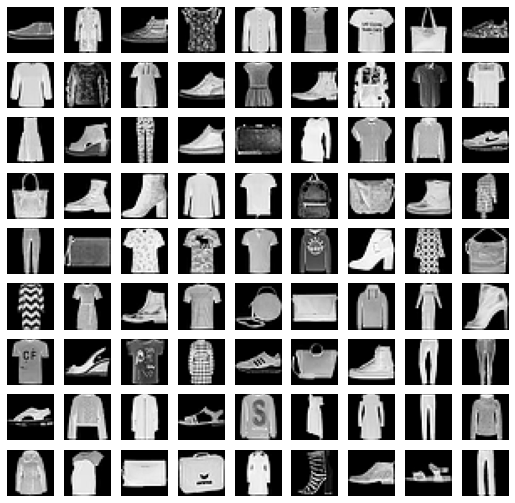

In [ ]:
idx = np.random.choice(list(range(X_train.shape[0])), 9*9)

fig = plt.figure(figsize=(9, 9))

rows = 9
cols = 9
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    img = X_train[idx[i-1]].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [ ]:
# Scale pixel values
X_train = X_train/255
X_test = X_test/255

# **Softmax regression**

In [ ]:
# Create model
class SoftmaxRegression():
    def __init__(self, n_features, n_classes):
        w = tf.random.normal((n_features, n_classes), mean=0.0, stddev=0.01, dtype=tf.float32)
        b = tf.zeros((1, n_classes))
        self.theta = tf.Variable(tf.concat((w, b), axis=0))

        self.train_losses = list()
        self.valid_losses = list()
        self.train_accs = list()
        self.valid_accs = list()

        self.scce = tf.keras.losses.SparseCategoricalCrossentropy()

    def predict(self, x):
        z = tf.matmul(self.theta, x, transpose_a=True)
        return tf.exp(z)/tf.math.reduce_sum(tf.exp(z), axis=0, keepdims=True)

    def fit(self, X, Y, batch_size, n_epochs, learning_rate, train_valid_split=0.8):
        data_size = X.shape[0]

        # Add intercept
        X = np.concatenate((X, np.ones((data_size, 1))), axis=1)

        # Shuffle
        idx = np.arange(data_size)
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        # Split train-valid
        train_size = round(data_size*train_valid_split)
        X_train = X[:train_size]
        Y_train = Y[:train_size]
        X_valid = X[train_size:]
        Y_valid = Y[train_size:]

        for epoch in tqdm(range(n_epochs), desc='Epochs: '):
            for i in range(0, data_size, batch_size):
                # Pick sample
                if i+batch_size > data_size:
                    x = X_train[i:].T
                    y = Y_train[i:]
                else:
                    x = X_train[i:i+batch_size].T
                    y = Y_train[i:i+batch_size]

                # Compute gradient
                with tf.GradientTape() as tape:
                    y_hat = self.predict(x)
                    loss = self.scce(y, tf.linalg.matrix_transpose(y_hat))
                    self.train_losses.append(loss)
                grad = tape.gradient(loss, self.theta)
                
                # Update parameters
                self.theta.assign_sub(learning_rate*grad)
                
                # Evaluate
                Y_hat_valid = self.predict(X_valid.T)
                v_loss = self.scce(Y_valid, tf.linalg.matrix_transpose(Y_hat_valid))
                self.valid_losses.append(v_loss)

                y_pred = self.predict(X_train.T)
                y_pred = tf.argmax(y_pred, axis=0)
                
                acc = np.mean(y_pred==Y_train.T)
                self.train_accs.append(acc)

                y_pred_valid = self.predict(X_valid.T)
                y_pred_valid = tf.argmax(y_pred_valid, axis=0)
                v_acc = np.mean(y_pred_valid==Y_valid.T)
                self.valid_accs.append(v_acc)
                print('\tLoss: {}\t Accuracy: {}'.format(loss.numpy(), acc))
    
    def plot_result(self):
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].set_title('Loss and Accuracy')
        axes[0].plot(self.train_losses, '-g', label='Train losses')
        axes[0].plot(self.valid_losses, '--r', label='Valid losses')
        axes[0].legend()
        axes[1].plot(self.train_accs, '-b', label='Train accuracy')
        axes[1].plot(self.valid_accs, ':k', label='Valid accuracy')
        axes[1].legend()

In [ ]:
n_features = X_train.shape[1]
n_classes = len(set(Y_train.tolist()))
model1 = SoftmaxRegression(n_features, n_classes)

batch_size = X_train.shape[0]//2
n_epochs = 50
learning_rate = 0.1
model1.fit(X_train, Y_train, batch_size, n_epochs, learning_rate)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

	Loss: 2.3082265853881836	 Accuracy: 0.3463125


Epochs:   2%|▏         | 1/50 [00:00<00:46,  1.04it/s]

	Loss: 2.062810182571411	 Accuracy: 0.6053333333333333
	Loss: 1.9055001735687256	 Accuracy: 0.6302083333333334


Epochs:   4%|▍         | 2/50 [00:01<00:46,  1.04it/s]

	Loss: 1.7740802764892578	 Accuracy: 0.64
	Loss: 1.6689122915267944	 Accuracy: 0.6565625


Epochs:   6%|▌         | 3/50 [00:02<00:45,  1.04it/s]

	Loss: 1.5778380632400513	 Accuracy: 0.6492708333333334
	Loss: 1.505008339881897	 Accuracy: 0.662875


Epochs:   8%|▊         | 4/50 [00:03<00:44,  1.04it/s]

	Loss: 1.4390811920166016	 Accuracy: 0.6541041666666667
	Loss: 1.3865824937820435	 Accuracy: 0.6660625


Epochs:  10%|█         | 5/50 [00:04<00:43,  1.04it/s]

	Loss: 1.3367350101470947	 Accuracy: 0.6579791666666667
	Loss: 1.2975218296051025	 Accuracy: 0.6688958333333334


Epochs:  12%|█▏        | 6/50 [00:05<00:42,  1.04it/s]

	Loss: 1.258354663848877	 Accuracy: 0.6617916666666667
	Loss: 1.228196144104004	 Accuracy: 0.6713958333333333


Epochs:  14%|█▍        | 7/50 [00:06<00:41,  1.04it/s]

	Loss: 1.1963974237442017	 Accuracy: 0.665375
	Loss: 1.1726497411727905	 Accuracy: 0.674625


Epochs:  16%|█▌        | 8/50 [00:07<00:40,  1.04it/s]

	Loss: 1.1461141109466553	 Accuracy: 0.6699375
	Loss: 1.1270577907562256	 Accuracy: 0.6778541666666666


Epochs:  18%|█▊        | 9/50 [00:08<00:39,  1.04it/s]

	Loss: 1.1043980121612549	 Accuracy: 0.6749166666666667
	Loss: 1.0888725519180298	 Accuracy: 0.6817708333333333


Epochs:  20%|██        | 10/50 [00:09<00:38,  1.04it/s]

	Loss: 1.0691452026367188	 Accuracy: 0.6805833333333333
	Loss: 1.0563411712646484	 Accuracy: 0.6859791666666667


Epochs:  22%|██▏       | 11/50 [00:10<00:37,  1.04it/s]

	Loss: 1.038885474205017	 Accuracy: 0.6853333333333333
	Loss: 1.0282230377197266	 Accuracy: 0.6902708333333333


Epochs:  24%|██▍       | 12/50 [00:11<00:36,  1.05it/s]

	Loss: 1.0125641822814941	 Accuracy: 0.6903541666666667
	Loss: 1.0036168098449707	 Accuracy: 0.6952083333333333


Epochs:  26%|██▌       | 13/50 [00:12<00:35,  1.05it/s]

	Loss: 0.9894053936004639	 Accuracy: 0.6960625
	Loss: 0.981852650642395	 Accuracy: 0.6997708333333333


Epochs:  28%|██▊       | 14/50 [00:13<00:34,  1.04it/s]

	Loss: 0.968826174736023	 Accuracy: 0.7007708333333333
	Loss: 0.9624232053756714	 Accuracy: 0.7046875


Epochs:  30%|███       | 15/50 [00:14<00:33,  1.04it/s]

	Loss: 0.9503805041313171	 Accuracy: 0.7059375
	Loss: 0.9449364542961121	 Accuracy: 0.709125


Epochs:  32%|███▏      | 16/50 [00:15<00:32,  1.05it/s]

	Loss: 0.933721125125885	 Accuracy: 0.7108541666666667
	Loss: 0.9290853142738342	 Accuracy: 0.7135416666666666


Epochs:  34%|███▍      | 17/50 [00:16<00:31,  1.05it/s]

	Loss: 0.9185736775398254	 Accuracy: 0.7157083333333333
	Loss: 0.9146255254745483	 Accuracy: 0.7173333333333334


Epochs:  36%|███▌      | 18/50 [00:17<00:30,  1.05it/s]

	Loss: 0.9047185182571411	 Accuracy: 0.7195208333333334
	Loss: 0.9013605713844299	 Accuracy: 0.7213333333333334


Epochs:  38%|███▊      | 19/50 [00:18<00:29,  1.05it/s]

	Loss: 0.8919775485992432	 Accuracy: 0.7235833333333334
	Loss: 0.8891298770904541	 Accuracy: 0.7250625


Epochs:  40%|████      | 20/50 [00:19<00:28,  1.04it/s]

	Loss: 0.8802049160003662	 Accuracy: 0.7267291666666666
	Loss: 0.8778018355369568	 Accuracy: 0.7279583333333334


Epochs:  42%|████▏     | 21/50 [00:20<00:27,  1.04it/s]

	Loss: 0.869280219078064	 Accuracy: 0.7295625
	Loss: 0.8672667145729065	 Accuracy: 0.7309583333333334


Epochs:  44%|████▍     | 22/50 [00:21<00:27,  1.04it/s]

	Loss: 0.8591024279594421	 Accuracy: 0.7328125
	Loss: 0.8574328422546387	 Accuracy: 0.733875


Epochs:  46%|████▌     | 23/50 [00:22<00:25,  1.04it/s]

	Loss: 0.8495872616767883	 Accuracy: 0.7358125
	Loss: 0.8482223749160767	 Accuracy: 0.7361041666666667


Epochs:  48%|████▊     | 24/50 [00:23<00:24,  1.04it/s]

	Loss: 0.8406624794006348	 Accuracy: 0.7386041666666666
	Loss: 0.8395695090293884	 Accuracy: 0.7386458333333333


Epochs:  50%|█████     | 25/50 [00:23<00:23,  1.05it/s]

	Loss: 0.8322669863700867	 Accuracy: 0.7411458333333333
	Loss: 0.8314176797866821	 Accuracy: 0.7411458333333333


Epochs:  52%|█████▏    | 26/50 [00:24<00:22,  1.04it/s]

	Loss: 0.8243480324745178	 Accuracy: 0.7433125
	Loss: 0.8237180113792419	 Accuracy: 0.7436875


Epochs:  54%|█████▍    | 27/50 [00:25<00:22,  1.04it/s]

	Loss: 0.816860020160675	 Accuracy: 0.7460208333333334
	Loss: 0.8164283633232117	 Accuracy: 0.7461666666666666


Epochs:  56%|█████▌    | 28/50 [00:26<00:21,  1.04it/s]

	Loss: 0.8097633719444275	 Accuracy: 0.7483333333333333
	Loss: 0.809511661529541	 Accuracy: 0.748125


Epochs:  58%|█████▊    | 29/50 [00:27<00:20,  1.05it/s]

	Loss: 0.8030234575271606	 Accuracy: 0.750125
	Loss: 0.8029356598854065	 Accuracy: 0.7502083333333334


Epochs:  60%|██████    | 30/50 [00:28<00:19,  1.04it/s]

	Loss: 0.79660964012146	 Accuracy: 0.7520625
	Loss: 0.796671986579895	 Accuracy: 0.7522916666666667


Epochs:  62%|██████▏   | 31/50 [00:29<00:18,  1.04it/s]

	Loss: 0.7904953360557556	 Accuracy: 0.7539583333333333
	Loss: 0.7906953692436218	 Accuracy: 0.7539583333333333


Epochs:  64%|██████▍   | 32/50 [00:30<00:17,  1.04it/s]

	Loss: 0.7846567034721375	 Accuracy: 0.7558125
	Loss: 0.7849834561347961	 Accuracy: 0.7557708333333333


Epochs:  66%|██████▌   | 33/50 [00:31<00:16,  1.04it/s]

	Loss: 0.7790724635124207	 Accuracy: 0.7577291666666667
	Loss: 0.7795162200927734	 Accuracy: 0.7572708333333333


Epochs:  68%|██████▊   | 34/50 [00:32<00:15,  1.04it/s]

	Loss: 0.7737237215042114	 Accuracy: 0.7590833333333333
	Loss: 0.7742758393287659	 Accuracy: 0.7589166666666667


Epochs:  70%|███████   | 35/50 [00:33<00:14,  1.04it/s]

	Loss: 0.7685935497283936	 Accuracy: 0.7606875
	Loss: 0.7692463397979736	 Accuracy: 0.7605833333333333


Epochs:  72%|███████▏  | 36/50 [00:34<00:13,  1.03it/s]

	Loss: 0.7636666893959045	 Accuracy: 0.761875
	Loss: 0.7644131779670715	 Accuracy: 0.7619375


Epochs:  74%|███████▍  | 37/50 [00:35<00:12,  1.03it/s]

	Loss: 0.758929431438446	 Accuracy: 0.7632916666666667
	Loss: 0.7597633004188538	 Accuracy: 0.7634166666666666


Epochs:  76%|███████▌  | 38/50 [00:36<00:11,  1.04it/s]

	Loss: 0.7543691992759705	 Accuracy: 0.7647916666666666
	Loss: 0.75528484582901	 Accuracy: 0.7647083333333333


Epochs:  78%|███████▊  | 39/50 [00:37<00:10,  1.03it/s]

	Loss: 0.74997478723526	 Accuracy: 0.7661041666666667
	Loss: 0.7509669661521912	 Accuracy: 0.7657083333333333


Epochs:  80%|████████  | 40/50 [00:38<00:09,  1.04it/s]

	Loss: 0.745735764503479	 Accuracy: 0.7676041666666666
	Loss: 0.7467999458312988	 Accuracy: 0.767125


Epochs:  82%|████████▏ | 41/50 [00:39<00:08,  1.04it/s]

	Loss: 0.7416428923606873	 Accuracy: 0.7685833333333333
	Loss: 0.7427746653556824	 Accuracy: 0.7683333333333333


Epochs:  84%|████████▍ | 42/50 [00:40<00:07,  1.04it/s]

	Loss: 0.7376875281333923	 Accuracy: 0.7698125
	Loss: 0.7388830184936523	 Accuracy: 0.7695


Epochs:  86%|████████▌ | 43/50 [00:41<00:06,  1.04it/s]

	Loss: 0.7338616251945496	 Accuracy: 0.7711041666666667
	Loss: 0.7351173758506775	 Accuracy: 0.7705625


Epochs:  88%|████████▊ | 44/50 [00:42<00:05,  1.04it/s]

	Loss: 0.7301582098007202	 Accuracy: 0.7723333333333333
	Loss: 0.7314708232879639	 Accuracy: 0.7719583333333333


Epochs:  90%|█████████ | 45/50 [00:43<00:04,  1.04it/s]

	Loss: 0.7265704274177551	 Accuracy: 0.7734166666666666
	Loss: 0.727936863899231	 Accuracy: 0.7728541666666666


Epochs:  92%|█████████▏| 46/50 [00:44<00:03,  1.04it/s]

	Loss: 0.7230921387672424	 Accuracy: 0.7745416666666667
	Loss: 0.7245096564292908	 Accuracy: 0.7738125


Epochs:  94%|█████████▍| 47/50 [00:45<00:02,  1.04it/s]

	Loss: 0.7197176814079285	 Accuracy: 0.7756666666666666
	Loss: 0.7211835980415344	 Accuracy: 0.775


Epochs:  96%|█████████▌| 48/50 [00:46<00:01,  1.04it/s]

	Loss: 0.7164417505264282	 Accuracy: 0.7765625
	Loss: 0.717953622341156	 Accuracy: 0.7760833333333333


Epochs:  98%|█████████▊| 49/50 [00:47<00:00,  1.05it/s]

	Loss: 0.7132593393325806	 Accuracy: 0.7775833333333333
	Loss: 0.7148151397705078	 Accuracy: 0.7774583333333334


Epochs: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]

	Loss: 0.7101660370826721	 Accuracy: 0.7783125


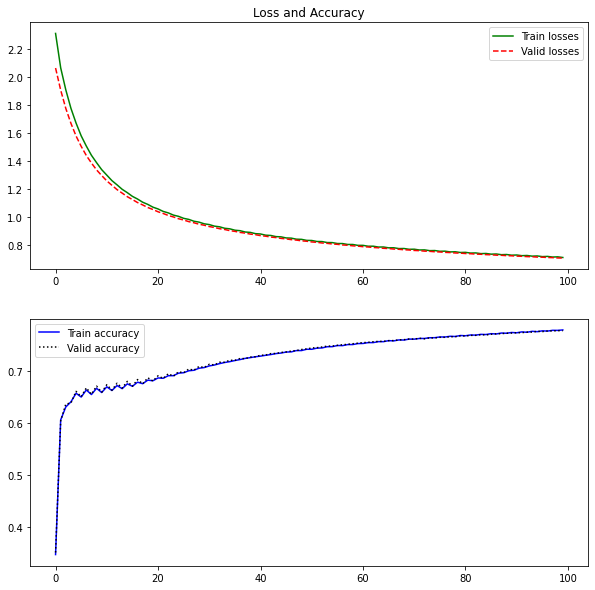

In [ ]:
model1.plot_result()

# **Softmax regression using Keras**

In [ ]:
input_shape = X_train.shape[1]
n_classes = len(set(Y_train.tolist()))

model2 = tf.keras.Sequential()
model2.add(tf.keras.Input(shape=input_shape))
model2.add(tf.keras.layers.Dense(n_classes, activation='softmax', 
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01), 
                                 bias_initializer='Zeros'))

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
data_size = X_train.shape[1]
# idx = np.arange(data_size)
# np.random.shuffle(idx)
# X_train = X_train[idx]
# Y_train = Y_train[idx]

batch_size = 512
n_epochs = 200

history = model2.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=n_epochs, verbose=1)

Epoch 1/200
94/94 [==============================] - 1s 5ms/step - loss: 0.4497 - accuracy: 0.8475 - val_loss: 0.4600 - val_accuracy: 0.8429
Epoch 2/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.8495 - val_loss: 0.4589 - val_accuracy: 0.8426
Epoch 3/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.8500 - val_loss: 0.4540 - val_accuracy: 0.8451
Epoch 4/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8512 - val_loss: 0.4541 - val_accuracy: 0.8446
Epoch 5/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8528 - val_loss: 0.4505 - val_accuracy: 0.8451
Epoch 6/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.8516 - val_loss: 0.4497 - val_accuracy: 0.8467
Epoch 7/200
94/94 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.8517 - val_loss: 0.4470 - val_accuracy: 0.8468
Epoch 8/200
9

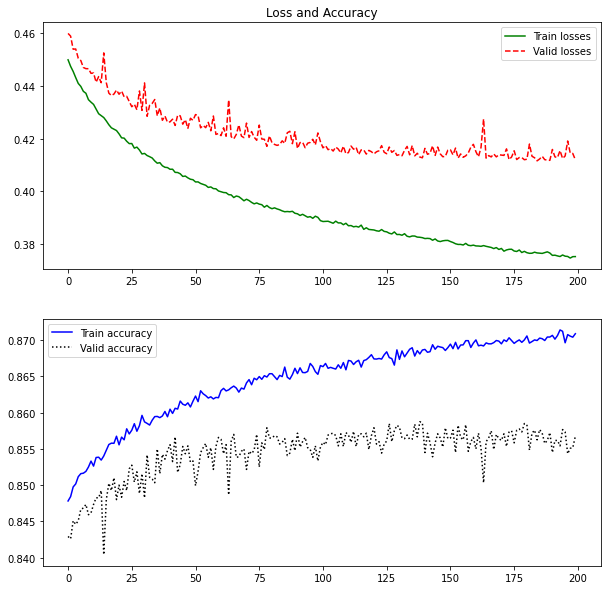

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Loss and Accuracy')
axes[0].plot(history.history['loss'], '-g', label='Train losses')
axes[0].plot(history.history['val_loss'], '--r', label='Valid losses')
axes[0].legend()
axes[1].plot(history.history['accuracy'], '-b', label='Train accuracy')
axes[1].plot(history.history['val_accuracy'], ':k', label='Valid accuracy')
axes[1].legend()

In [ ]:
model2.evaluate(X_test, Y_test, batch_size)

20/20 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.8453


[0.43753525614738464, 0.845300018787384]

# **Multi-layer perceptron**

In [ ]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.Input(shape=input_shape))
model3.add(tf.keras.layers.Dense(256, activation='relu',
                                 kernel_initializer=tf.keras.initializers.RandomNormal(),
                                 bias_initializer='Zeros'))
model3.add(tf.keras.layers.Dense(n_classes, activation='softmax', 
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01), 
                                 bias_initializer='Zeros'))

In [ ]:
model3.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 512
n_epochs = 200

history3 = model3.fit(X_train, Y_train, validation_split=0.2, epochs=n_epochs, batch_size=batch_size)

Epoch 1/200
94/94 [==============================] - 1s 5ms/step - loss: 2.1806 - accuracy: 0.3050 - val_loss: 1.8032 - val_accuracy: 0.6348
Epoch 2/200
94/94 [==============================] - 0s 3ms/step - loss: 1.6824 - accuracy: 0.6338 - val_loss: 1.3599 - val_accuracy: 0.6554
Epoch 3/200
94/94 [==============================] - 0s 3ms/step - loss: 1.2958 - accuracy: 0.6540 - val_loss: 1.1129 - val_accuracy: 0.6696
Epoch 4/200
94/94 [==============================] - 0s 4ms/step - loss: 1.0808 - accuracy: 0.6673 - val_loss: 0.9778 - val_accuracy: 0.6908
Epoch 5/200
94/94 [==============================] - 0s 3ms/step - loss: 0.9660 - accuracy: 0.6867 - val_loss: 0.8954 - val_accuracy: 0.7065
Epoch 6/200
94/94 [==============================] - 0s 3ms/step - loss: 0.8907 - accuracy: 0.7040 - val_loss: 0.8399 - val_accuracy: 0.7214
Epoch 7/200
94/94 [==============================] - 0s 3ms/step - loss: 0.8454 - accuracy: 0.7161 - val_loss: 0.7983 - val_accuracy: 0.7295
Epoch 8/200
9

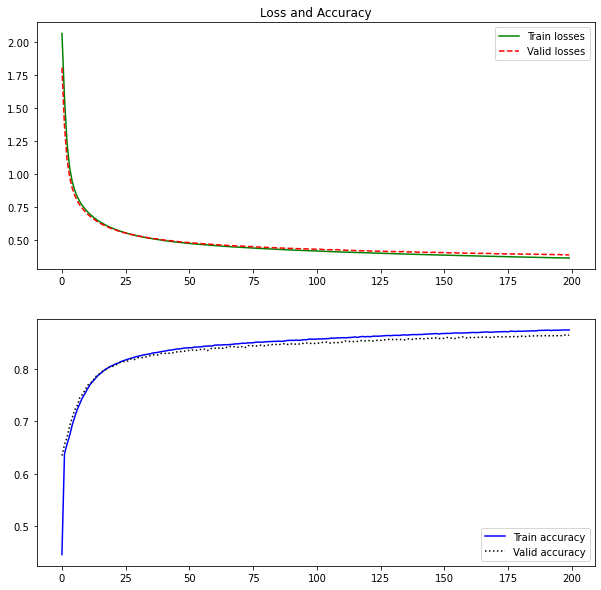

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Loss and Accuracy')
axes[0].plot(history3.history['loss'], '-g', label='Train losses')
axes[0].plot(history3.history['val_loss'], '--r', label='Valid losses')
axes[0].legend()
axes[1].plot(history3.history['accuracy'], '-b', label='Train accuracy')
axes[1].plot(history3.history['val_accuracy'], ':k', label='Valid accuracy')
axes[1].legend()

In [ ]:
model3.evaluate(X_test, Y_test, batch_size)

20/20 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.8534


[0.4130196273326874, 0.8533999919891357]

# **MLP using He-normal and Adam**

In [ ]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.Input(shape=input_shape))
model4.add(tf.keras.layers.Dense(256, activation='relu',
                                 kernel_initializer=tf.keras.initializers.HeNormal(),
                                 bias_initializer='Zeros'))
model4.add(tf.keras.layers.Dense(128, activation='relu',
                                 kernel_initializer=tf.keras.initializers.HeNormal(),
                                 bias_initializer='Zeros'))
model4.add(tf.keras.layers.Dense(n_classes, activation='softmax', 
                                 kernel_initializer=tf.keras.initializers.HeNormal(), 
                                 bias_initializer='Zeros'))

In [ ]:
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 512
n_epochs = 200

history4 = model4.fit(X_train, Y_train, validation_split=0.2, 
                      epochs=n_epochs, batch_size=batch_size, 
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/200
94/94 [==============================] - 1s 5ms/step - loss: 0.9880 - accuracy: 0.6659 - val_loss: 0.4604 - val_accuracy: 0.8396
Epoch 2/200
94/94 [==============================] - 0s 4ms/step - loss: 0.4441 - accuracy: 0.8449 - val_loss: 0.4083 - val_accuracy: 0.8573
Epoch 3/200
94/94 [==============================] - 0s 4ms/step - loss: 0.3898 - accuracy: 0.8629 - val_loss: 0.3732 - val_accuracy: 0.8671
Epoch 4/200
94/94 [==============================] - 0s 4ms/step - loss: 0.3430 - accuracy: 0.8777 - val_loss: 0.3599 - val_accuracy: 0.8698
Epoch 5/200
94/94 [==============================] - 0s 4ms/step - loss: 0.3243 - accuracy: 0.8851 - val_loss: 0.3483 - val_accuracy: 0.8771
Epoch 6/200
94/94 [==============================] - 0s 4ms/step - loss: 0.3101 - accuracy: 0.8870 - val_loss: 0.3358 - val_accuracy: 0.8793
Epoch 7/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2890 - accuracy: 0.8960 - val_loss: 0.3378 - val_accuracy: 0.8761
Epoch 8/200
9

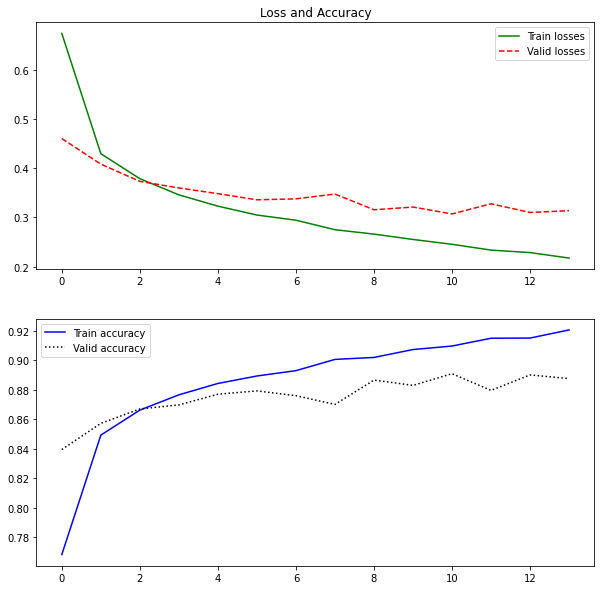

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Loss and Accuracy')
axes[0].plot(history4.history['loss'], '-g', label='Train losses')
axes[0].plot(history4.history['val_loss'], '--r', label='Valid losses')
axes[0].legend()
axes[1].plot(history4.history['accuracy'], '-b', label='Train accuracy')
axes[1].plot(history4.history['val_accuracy'], ':k', label='Valid accuracy')
axes[1].legend()

In [ ]:
model4.evaluate(X_test, Y_test, batch_size)

20/20 [==============================] - 0s 2ms/step - loss: 0.3374 - accuracy: 0.8830


[0.3374224007129669, 0.8830000162124634]